# **Demographic Population Growth**

- Using 2023 as a base, calculate change in population for each demographic group (0-4,5-9 etc), calculating the population change factor from ONS Projections.
- Creating GP List Projections, using the number of patients registered at GP list and population change factor from ONS Projections.
- Comparing and analysing ONS Projections and GP list Projections for each SNEE ICB areas
- Repeating the same for other ONS Scenarios

### **Importing libraries**

In [1]:
# this is a bit of a hack to get relative imports 
# to work as if these notebooks were in a package
from os import chdir
from pathlib import Path
if 'notebooks' in str(Path.cwd()):
    chdir('..')

from typing import Dict

import yaml
yaml.Dumper.ignore_aliases = lambda *args : True

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from src.schemas import DataCatalog

# project imports from src
from src.various_methods import PlotCounter
import src.constants as constants
# Importing SNEE styles
from sneeifstyles import mpl_style
mpl_style()

from time import sleep

## Module Constants

In [2]:
GP_LIST_OCT_2023 = 'Patients Registered at a GP practice, October 2023' # name of the GP list file
SNEE_SUBICB_CODES = list(constants.SUB_ICB_CODES.keys()) # list of sub-icb codes for SNEE
GP_LIST_AGE_BANDS = constants.GP_LIST_AGE_BANDS # age bands for GP list
GP_LIST_LABELS = constants.GP_LIST_AGE_LABELS # labels for GP list
OVER_65_LABELS = GP_LIST_LABELS[-6:]

In [3]:
print(f'GP_LIST_AGE_BANDS: {GP_LIST_AGE_BANDS}')
print(len(GP_LIST_AGE_BANDS))

GP_LIST_AGE_BANDS: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 200]
20


In [4]:
print(f'GP_LIST_AGE_BANDS: {GP_LIST_LABELS}')
print(len(GP_LIST_LABELS))

GP_LIST_AGE_BANDS: ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']
19


### **Loading the Data catalogue**

In [5]:
catalog =  DataCatalog.load_from_yaml("data_catalog.yaml")

In [6]:
#Initializing the plotCounter object
plot_counter = PlotCounter(name='demographic_pop_growth')

## **Loading & Preprocessing the Dataset - 'Patients Registered at a GP practice, October 2023'**

In [7]:
#Loading the Dataset to get data on number of patients from GP List
gp_patients_reg_catalog_entry = catalog.get_catalog_entry_by_name(GP_LIST_OCT_2023)
gp_patients_df = gp_patients_reg_catalog_entry.load()
gp_patients_df.head()

/workspaces/PrimaryCareDemandAndCapacity/src/schemas.py:146: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_file, **read_csv_kwargs)


,PUBLICATION,EXTRACT_DATE,ORG_TYPE,ORG_CODE,ONS_CODE,POSTCODE,SEX,AGE_GROUP_5,NUMBER_OF_PATIENTS
0,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,ALL,ALL,10927943
1,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,FEMALE,0_4,258852
2,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,FEMALE,10_14,300771
3,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,FEMALE,15_19,287618
4,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,FEMALE,20_24,385681


In [8]:
#Replacing AGE_BANDS values to match the ONS_projection data
def rename_gp_list_age_bands_and_columns(df):
    """
    Renames age bands and columns in the given DataFrame to match ONS projections.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data to be processed.

    Returns:
        pandas.DataFrame: A copy of the input DataFrame with the age bands and columns renamed.
    """
    df_ = df.copy()
    # replace these specific cases
    df_['AGE_GROUP_5'] = df_['AGE_GROUP_5'].replace({'90_94':'90+', '95+':'90+'})
    # change _ to - for consistency with ONS projections
    df_['AGE_GROUP_5'] = df_['AGE_GROUP_5'].str.replace('_','-')
    #Renaming the column name to match with ONS projection data
    df_ = df_.rename(columns={'ONS_CODE':'AREA_CODE'})
    return df_
    
def filter_gp_list_and_drop_unused_columns(df):
    """
    Filters the given DataFrame by dropping unused columns and rows corresponding to 'ALL' for AGE_GROUP_5.
    
    Args:
        df (pandas.DataFrame): The input DataFrame to be filtered.
        
    Returns:
        pandas.DataFrame: The filtered DataFrame with dropped columns and rows.
    """
    df_ = df.copy()
    # Dropping unused columns and rows corresponding to 'ALL' for AGE_GROUP_5 
    df_ = df_.loc[df_['AGE_GROUP_5']!='ALL']
    # This is due to the 'ALL' row being a sum of all the other rows, the 'SEX' == ALL rows are also dropped
    df_ = df_.drop(columns=['PUBLICATION','EXTRACT_DATE','ORG_TYPE','POSTCODE','SEX'])
    # Set ONS area code as index
    df = df_.set_index('AREA_CODE')
    return df_

gp_patients_df = (gp_patients_df
                  .pipe(rename_gp_list_age_bands_and_columns)
                  .pipe(filter_gp_list_and_drop_unused_columns))

gp_patients_df.head(20)

,ORG_CODE,AREA_CODE,AGE_GROUP_5,NUMBER_OF_PATIENTS
1,Y56,E40000003,0-4,258852
2,Y56,E40000003,10-14,300771
3,Y56,E40000003,15-19,287618
4,Y56,E40000003,20-24,385681
5,Y56,E40000003,25-29,535500
6,Y56,E40000003,30-34,542326
7,Y56,E40000003,35-39,487457
8,Y56,E40000003,40-44,422343
9,Y56,E40000003,45-49,349285
10,Y56,E40000003,50-54,316857


### **Filtering the data for Sub-ICB's under SNEE ICB**

In [9]:
def filter_snee_icb_areas(df):
    """
    Filters the given DataFrame based on the 'ORG_CODE' column, keeping only the rows
    where the 'ORG_CODE' is in the list of SNEE_SUBICB_CODES.
    
    Args:
        df (pandas.DataFrame): The DataFrame to be filtered.
        
    Returns:
        pandas.DataFrame: The filtered DataFrame.
    """
    # copy original df
    df_ = df.copy()
    df_ = df_.loc[df_['ORG_CODE'].isin(SNEE_SUBICB_CODES)]
    return df_

def groupbysum_area_and_age_group_and_rename_ons_codes(df):
    """
    Groups the DataFrame by AREA_CODE and AGE_GROUP_5, sums the values, drops the ORG_CODE column,
    and renames the index using ONS_CODES.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The modified DataFrame with grouped, summed, and renamed values.
    """
    df_ = df.copy()
    # Grouping by AREA_CODE and AGE_GROUP_5 and summing the values
    df_ = df_.groupby(['AREA_CODE','AGE_GROUP_5']).sum()
    # drop the org_code column as not used (ONS area code is the index)
    df_ = df_.drop(columns=['ORG_CODE'])

    df_ = df_.rename(index=constants.ONS_CODES)

    return df_


gp_patients_df = (gp_patients_df
                  .pipe(filter_snee_icb_areas)
                  .pipe(groupbysum_area_and_age_group_and_rename_ons_codes)
                    )

gp_patients_df.head(25)

NUMBER_OF_PATIENTS
AREA_CODE              AGE_GROUP_5                    
Ipswich & East Suffolk 0-4                       18148
                       10-14                     24231
                       15-19                     23513
                       20-24                     19718
                       25-29                     22975
                       30-34                     26197
                       35-39                     27046
                       40-44                     26757
                       45-49                     24675
                       5-9                       22318
                       50-54                     28246
                       55-59                     29474
                       60-64                     27504
                       65-69                     24094
                       70-74                     22465
                       75-79                     21514
                       80-84                     13002
                       85-89                      8418
                       90+                        4944
North East Essex       0-4                       17141
                       10-14                     21753
                       15-19                     19603
                       20-24                     22057
                       25-29                     23587
                       30-34                     25308

## Loading ONS Population projections
### Principal Projection

In [10]:
# just load the first scenario
ons_projection_catalog_entry = catalog.get_scenario_catalog_entry_by_name('ONS Population projections','Principal projection')
ons_projections_df = ons_projection_catalog_entry.load()
ons_projections_df.head()

,AREA_CODE,AREA_NAME,COMPONENT,SEX,AGE_GROUP,2018,2019,2020,2021,2022,...,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043
0,E38000004,NHS Barking and Dagenham CCG,Population,persons,0,3819.0,3539.476,3553.996,3545.026,3503.164,...,3485.017,3512.290,3542.499,3574.884,3607.783,3638.390,3663.012,3682.648,3697.617,3706.681
1,E38000004,NHS Barking and Dagenham CCG,Population,persons,1,3923.0,3841.214,3570.205,3583.060,3571.184,...,3482.414,3507.074,3534.224,3564.456,3597.080,3630.402,3661.624,3687.005,3707.455,3723.301
2,E38000004,NHS Barking and Dagenham CCG,Population,persons,2,4050.0,3912.292,3826.447,3565.341,3575.791,...,3448.544,3469.903,3494.032,3520.703,3550.533,3582.885,3616.072,3647.352,3672.985,3693.800
3,E38000004,NHS Barking and Dagenham CCG,Population,persons,3,3822.0,4036.658,3906.033,3816.546,3563.662,...,3426.572,3442.075,3462.911,3486.569,3512.830,3542.304,3574.383,3607.421,3638.690,3664.447
4,E38000004,NHS Barking and Dagenham CCG,Population,persons,4,3905.0,3805.264,4003.299,3879.217,3788.087,...,3394.732,3405.045,3420.062,3440.323,3463.422,3489.140,3518.097,3549.706,3582.360,3613.373


### Cleaning data
- Removing 'all ages' rows
- removing columns prior to 2023
- removing 'AREA NAME' and 'SEX' column

In [11]:
#Removing values corresponding to 'All ages' in the 'AGE_GROUP' column and dropping unused columns

def rename_ons_columns_and_drop_unused(df) -> pd.DataFrame:
    """
    Rename columns in the DataFrame and drop unused columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: The modified DataFrame with renamed and dropped columns.
    """
    df_ = df.copy()
    df_ = df_.loc[df_['AGE_GROUP'] != 'All ages']
    df_ = df_.drop(columns=['AREA_NAME', 'COMPONENT', 'SEX', '2018', '2019', '2020', '2021', '2022'])
    df_ = df_.set_index('AREA_CODE')
    return df_
def rename_ons_columns_and_drop_unused(df)->pd.DataFrame:

    df_ = df.copy()
    df_ = df_.loc[df_['AGE_GROUP']!='All ages']
    df_ = df_.drop(columns=['AREA_NAME','COMPONENT','SEX','2018','2019','2020','2021','2022'])
    df_ = df_.set_index('AREA_CODE')
    return df_

ons_projections_df = ons_projections_df.pipe(rename_ons_columns_and_drop_unused)   
ons_projections_df.head(20)

,AGE_GROUP,2023,2024,2025,2026,2027,2028,2029,2030,2031,...,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043
AREA_CODE,,,,,,,,,,,,,,,,,,,,,
E38000004,0,3469.075,3437.253,3428.219,3418.083,3406.972,3400.285,3399.890,3408.270,3420.751,...,3485.017,3512.290,3542.499,3574.884,3607.783,3638.390,3663.012,3682.648,3697.617,3706.681
E38000004,1,3529.219,3494.651,3462.900,3453.457,3443.087,3431.919,3424.981,3424.216,3431.942,...,3482.414,3507.074,3534.224,3564.456,3597.080,3630.402,3661.624,3687.005,3707.455,3723.301
E38000004,2,3561.177,3519.204,3484.008,3453.543,3443.862,3433.423,3422.364,3415.261,3414.190,...,3448.544,3469.903,3494.032,3520.703,3550.533,3582.885,3616.072,3647.352,3672.985,3693.800
E38000004,3,3572.051,3554.902,3512.813,3478.309,3448.940,3439.117,3428.663,3417.715,3410.517,...,3426.572,3442.075,3462.911,3486.569,3512.830,3542.304,3574.383,3607.421,3638.690,3664.447
E38000004,4,3543.565,3549.867,3530.741,3489.970,3456.359,3428.155,3418.331,3407.972,3397.239,...,3394.732,3405.045,3420.062,3440.323,3463.422,3489.140,3518.097,3549.706,3582.360,3613.373
E38000004,5,3717.477,3482.576,3487.301,3468.027,3428.801,3396.377,3369.526,3359.861,3349.759,...,3330.840,3336.600,3346.469,3360.947,3380.534,3402.936,3427.918,3456.106,3486.946,3518.882
E38000004,6,3755.424,3663.975,3436.592,3440.985,3421.540,3383.508,3352.025,3326.214,3316.665,...,3289.746,3288.215,3293.698,3303.214,3317.279,3336.354,3358.215,3382.637,3410.235,3440.476
E38000004,7,3809.760,3699.745,3608.021,3389.104,3393.151,3373.673,3336.820,3306.289,3281.535,...,3252.650,3245.888,3244.339,3249.572,3258.751,3272.412,3290.966,3312.286,3336.128,3363.123
E38000004,8,3585.291,3734.218,3628.456,3538.194,3327.651,3331.456,3312.027,3276.414,3246.883,...,3204.571,3195.057,3188.456,3186.921,3191.901,3200.748,3213.996,3232.008,3252.755,3275.981


In [12]:
ons_projections_df['AGE_GROUP'].value_counts().sort_index()

AGE_GROUP
0              195
1              195
10             195
11             195
12             195
              ... 
87             195
88             195
89             195
9              195
90 and over    195
Name: count, Length: 91, dtype: int64

### Apply 5 year age bands to ONS yearly population estimates
- Add column with 5 year age banding

In [13]:
#Specifying the bins and labels for new AGE BANDS columns

def convert_ons_projection_to_5yr_bins(df):
    """
    Convert the ONS projection data to 5-year age bands.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the ONS projection data.

    Returns:
        pandas.DataFrame: The DataFrame with the ONS projection data converted to 5-year age bands.
    """
    df_ = df.copy()

    # replace the text '90 and over' with '90' to match the GP list data
    df_['AGE_GROUP'] = df_['AGE_GROUP'].astype(str).str.replace('90 and over','90')
    #Converting AGE_GROUP data type to int
    df_['AGE_GROUP'] = df_['AGE_GROUP'].astype(int)

    #Adding the column for Age Bands as 'AGE_GROUP_5'
    df_['AGE_GROUP_5'] = pd.cut(df_['AGE_GROUP'], bins=GP_LIST_AGE_BANDS, labels=GP_LIST_LABELS, include_lowest=True, right=False, ordered=True)
    return df_

ons_projections_df = ons_projections_df.pipe(convert_ons_projection_to_5yr_bins)

ons_projections_df.head(25)

,AGE_GROUP,2023,2024,2025,2026,2027,2028,2029,2030,2031,...,2035,2036,2037,2038,2039,2040,2041,2042,2043,AGE_GROUP_5
AREA_CODE,,,,,,,,,,,,,,,,,,,,,
E38000004,0,3469.075,3437.253,3428.219,3418.083,3406.972,3400.285,3399.890,3408.270,3420.751,...,3512.290,3542.499,3574.884,3607.783,3638.390,3663.012,3682.648,3697.617,3706.681,0-4
E38000004,1,3529.219,3494.651,3462.900,3453.457,3443.087,3431.919,3424.981,3424.216,3431.942,...,3507.074,3534.224,3564.456,3597.080,3630.402,3661.624,3687.005,3707.455,3723.301,0-4
E38000004,2,3561.177,3519.204,3484.008,3453.543,3443.862,3433.423,3422.364,3415.261,3414.190,...,3469.903,3494.032,3520.703,3550.533,3582.885,3616.072,3647.352,3672.985,3693.800,0-4
E38000004,3,3572.051,3554.902,3512.813,3478.309,3448.940,3439.117,3428.663,3417.715,3410.517,...,3442.075,3462.911,3486.569,3512.830,3542.304,3574.383,3607.421,3638.690,3664.447,0-4
E38000004,4,3543.565,3549.867,3530.741,3489.970,3456.359,3428.155,3418.331,3407.972,3397.239,...,3405.045,3420.062,3440.323,3463.422,3489.140,3518.097,3549.706,3582.360,3613.373,0-4
E38000004,5,3717.477,3482.576,3487.301,3468.027,3428.801,3396.377,3369.526,3359.861,3349.759,...,3336.600,3346.469,3360.947,3380.534,3402.936,3427.918,3456.106,3486.946,3518.882,5-9
E38000004,6,3755.424,3663.975,3436.592,3440.985,3421.540,3383.508,3352.025,3326.214,3316.665,...,3288.215,3293.698,3303.214,3317.279,3336.354,3358.215,3382.637,3410.235,3440.476,5-9
E38000004,7,3809.760,3699.745,3608.021,3389.104,3393.151,3373.673,3336.820,3306.289,3281.535,...,3245.888,3244.339,3249.572,3258.751,3272.412,3290.966,3312.286,3336.128,3363.123,5-9
E38000004,8,3585.291,3734.218,3628.456,3538.194,3327.651,3331.456,3312.027,3276.414,3246.883,...,3195.057,3188.456,3186.921,3191.901,3200.748,3213.996,3232.008,3252.755,3275.981,5-9


### Filtering the data for Sub-ICB's under SNEE ICB
- Filter to only SNEE ICB areas
- Group by sum on 5 year age group

In [14]:
ons_projections_df

,AGE_GROUP,2023,2024,2025,2026,2027,2028,2029,2030,2031,...,2035,2036,2037,2038,2039,2040,2041,2042,2043,AGE_GROUP_5
AREA_CODE,,,,,,,,,,,,,,,,,,,,,
E38000004,0,3469.075,3437.253,3428.219,3418.083,3406.972,3400.285,3399.890,3408.270,3420.751,...,3512.290,3542.499,3574.884,3607.783,3638.390,3663.012,3682.648,3697.617,3706.681,0-4
E38000004,1,3529.219,3494.651,3462.900,3453.457,3443.087,3431.919,3424.981,3424.216,3431.942,...,3507.074,3534.224,3564.456,3597.080,3630.402,3661.624,3687.005,3707.455,3723.301,0-4
E38000004,2,3561.177,3519.204,3484.008,3453.543,3443.862,3433.423,3422.364,3415.261,3414.190,...,3469.903,3494.032,3520.703,3550.533,3582.885,3616.072,3647.352,3672.985,3693.800,0-4
E38000004,3,3572.051,3554.902,3512.813,3478.309,3448.940,3439.117,3428.663,3417.715,3410.517,...,3442.075,3462.911,3486.569,3512.830,3542.304,3574.383,3607.421,3638.690,3664.447,0-4
E38000004,4,3543.565,3549.867,3530.741,3489.970,3456.359,3428.155,3418.331,3407.972,3397.239,...,3405.045,3420.062,3440.323,3463.422,3489.140,3518.097,3549.706,3582.360,3613.373,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E38000152,86,1628.211,1636.017,1706.991,1688.244,1608.515,1873.938,2110.041,2267.063,2270.099,...,2615.571,2495.617,2451.543,2416.598,2561.461,2533.588,2544.496,2628.319,2762.469,85-89
E38000152,87,1402.339,1465.751,1474.123,1537.948,1523.015,1451.924,1691.045,1904.724,2048.219,...,2492.084,2372.881,2266.242,2228.551,2197.967,2331.509,2311.180,2321.696,2401.460,85-89
E38000152,88,1240.141,1279.098,1337.801,1346.802,1405.211,1393.591,1329.285,1548.077,1743.015,...,2531.128,2291.237,2181.341,2088.643,2055.192,2028.835,2152.992,2135.857,2148.003,85-89


In [15]:
def filter_ons_to_snee_icb(df):
    """
    Filters the input DataFrame based on the index values that match the ONS codes.
    
    Parameters:
        df (pandas.DataFrame): The input DataFrame to be filtered.
        
    Returns:
        pandas.DataFrame: The filtered DataFrame.
    """
    df_ = df.copy()
    df_ = df_.loc[df_.index.isin(list(constants.ONS_CODES.keys()))]
    return df_

def ons_groupbysum_area_and_age_group_5(df):
    """
    Groups the DataFrame by 'AREA_CODE' and 'AGE_GROUP_5' columns and calculates the sum of other columns.
    
    Args:
        df (DataFrame): The input DataFrame.
        
    Returns:
        DataFrame: The grouped DataFrame with the sum of other columns.
    """
    df_ = df.copy()
    df_ = df_.groupby(['AREA_CODE','AGE_GROUP_5']).sum()
    df_ = df_.drop(columns=['AGE_GROUP'])
    return df_

ons_projections_df =  (ons_projections_df
                       .pipe(filter_ons_to_snee_icb)
                       .pipe(ons_groupbysum_area_and_age_group_5)
                       .rename(index=constants.ONS_CODES)
                       )
ons_projections_df.head(25)

/tmp/ipykernel_37149/2329580713.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ = df_.groupby(['AREA_CODE','AGE_GROUP_5']).sum()


2023       2024       2025  \
AREA_CODE              AGE_GROUP_5                                    
Ipswich & East Suffolk 0-4          19769.942  19698.373  19604.966   
                       5-9          22791.554  22378.224  21998.493   
                       10-14        25096.067  25016.257  24783.209   
                       15-19        23195.390  23496.655  23897.784   
                       20-24        17350.547  17173.888  17191.096   
                       25-29        21952.574  21725.747  21375.379   
                       30-34        23507.025  23322.637  23120.071   
                       35-39        24457.341  24853.931  24919.890   
                       40-44        24628.666  24649.939  24662.459   
                       45-49        23605.307  23458.866  23790.455   
                       50-54        28999.109  28177.625  27319.980   
                       55-59        30950.239  30959.251  30740.225   
                       60-64        28895.939  29748.494  30672.459   
                       65-69        26198.598  26622.938  27166.129   
                       70-74        24609.158  24440.948  24290.360   
                       75-79        23018.558  23638.795  24103.485   
                       80-84        14084.989  14826.670  15622.169   
                       85-89         9210.222   9489.764   9586.131   
                       90+           5445.068   5556.679   5738.342   
North East Essex       0-4          18308.483  18412.980  18487.602   
                       5-9          20182.233  19960.184  19750.128   
                       10-14        20958.477  21259.324  21428.853   
                       15-19        20313.529  20846.217  21487.352   
                       20-24        21836.830  21843.572  22001.083   
                       25-29        21594.273  21499.431  21498.879   

                                         2026       2027       2028  \
AREA_CODE              AGE_GROUP_5                                    
Ipswich & East Suffolk 0-4          19527.257  19483.805  19446.523   
                       5-9          21529.082  21261.284  21050.186   
                       10-14        24569.717  24249.751  24005.345   
                       15-19        24193.275  24317.998  24191.858   
                       20-24        17520.013  17987.881  18489.898   
                       25-29        20907.182  20292.914  19940.445   
                       30-34        22821.818  22673.019  22524.456   
                       35-39        25052.567  24997.789  24739.708   
                       40-44        24742.487  24875.434  25249.593   
                       45-49        24298.509  24929.913  25339.023   
                       50-54        26175.839  25254.618  24507.293   
                       55-59        30651.562  30267.819  29908.473   
                       60-64        31109.610  31588.492  31641.883   
                       65-69        28060.531  28547.831  29218.619   
                       70-74        24335.535  24846.839  25431.234   
                       75-79        24288.534  23071.573  22541.223   
                       80-84        16631.354  18580.954  19602.032   
                       85-89         9593.809   9892.200  10307.361   
                       90+           5872.474   6030.621   6236.282   
North East Essex       0-4          18567.698  18647.111  18715.397   
                       5-9          19636.743  19543.362  19482.348   
                       10-14        21475.892  21237.531  21118.375   
                       15-19        21986.365  22662.033  22986.959   
                       20-24        22378.898  22972.906  23624.911   
                       25-29        21287.801  20932.246  20688.774   

                                         2029       2030       2031  \
AREA_CODE              AGE_GROUP_5                                    
Ipswich & East Suffolk 0-4          19414.341  19391.237  19381

### Calculating the population change factor for each year 
- 2023 as baseline

In [16]:
# create a baseline (series/1 column)
pop_baseline:pd.Series = ons_projections_df['2023']
# divide the projections by the baseline to get the relative factors
snee_factors_ons_projections:pd.DataFrame = ons_projections_df.div(pop_baseline, axis=0).round(5)


In [17]:
snee_factors_ons_projections.head(30)

2023     2024     2025     2026     2027  \
AREA_CODE              AGE_GROUP_5                                             
Ipswich & East Suffolk 0-4           1.0  0.99638  0.99166  0.98772  0.98553   
                       5-9           1.0  0.98186  0.96520  0.94461  0.93286   
                       10-14         1.0  0.99682  0.98753  0.97903  0.96628   
                       15-19         1.0  1.01299  1.03028  1.04302  1.04840   
                       20-24         1.0  0.98982  0.99081  1.00977  1.03673   
                       25-29         1.0  0.98967  0.97371  0.95238  0.92440   
                       30-34         1.0  0.99216  0.98354  0.97085  0.96452   
                       35-39         1.0  1.01622  1.01891  1.02434  1.02210   
                       40-44         1.0  1.00086  1.00137  1.00462  1.01002   
                       45-49         1.0  0.99380  1.00784  1.02937  1.05611   
                       50-54         1.0  0.97167  0.94210  0.90264  0.87088   
                       55-59         1.0  1.00029  0.99321  0.99035  0.97795   
                       60-64         1.0  1.02950  1.06148  1.07661  1.09318   
                       65-69         1.0  1.01620  1.03693  1.07107  1.08967   
                       70-74         1.0  0.99316  0.98705  0.98888  1.00966   
                       75-79         1.0  1.02695  1.04713  1.05517  1.00230   
                       80-84         1.0  1.05266  1.10914  1.18079  1.31920   
                       85-89         1.0  1.03035  1.04081  1.04165  1.07405   
                       90+           1.0  1.02050  1.05386  1.07849  1.10754   
North East Essex       0-4           1.0  1.00571  1.00978  1.01416  1.01850   
                       5-9           1.0  0.98900  0.97859  0.97297  0.96834   
                       10-14         1.0  1.01435  1.02244  1.02469  1.01331   
                       15-19         1.0  1.02622  1.05779  1.08235  1.11561   
                       20-24         1.0  1.00031  1.00752  1.02482  1.05203   
                       25-29         1.0  0.99561  0.99558  0.98581  0.96934   
                       30-34         1.0  1.00131  0.98774  0.97250  0.96267   
                       35-39         1.0  1.03335  1.06079  1.09679  1.12051   
                       40-44         1.0  1.00846  1.01943  1.02817  1.04268   
                       45-49         1.0  1.00111  1.01003  1.03046  1.05068   
                       50-54         1.0  0.97398  0.95924  0.93052  0.90756   

                                       2028     2029     2030     2031  \
AREA_CODE              AGE_GROUP_5                                       
Ipswich & East Suffolk 0-4          0.98364  0.98201  0.98084  0.98037   
                       5-9          0.92360  0.92068  0.91683  0.91373   
                       10-14        0.95654  0.93978  0.92478  0.90588   
                       15-19        1.04296  1.03836  1.02874  1.02327   
                       20-24        1.06567  1.08405  1.10702  1.12416   
                       25-29        0.90834  0.90184  0.90465  0.92140   
                       30-34        0.95820  0.94830  0.93494  0.91664   
                       35-39        1.01155  1.00474  0.99585  0.98348   
                       40-44        1.02521  1.04107  1.04453  1.05066   
                       45-49        1.07345  1.07508  1.07585  1.07972   
                       50-54        0.84511  0.84131  0.85352  0.87141   
                       55-59        0.96634  0.94008  0.91348  0.87715   
                       60-64        1.09503  1.09520  1.08818  1.08528   
                       65-69        1.11527  1.14889  1.18407  1.20191   
                       70-74        1.03341  1.05151  1.07421  1.10985   
                       75-79        0.97926  0.97372  0.96899  0.97236   
                       80-84        1.39170  1.42875  1.45659  1.46643   
                       85-89        1.11912  1.18464  1.25023  1.3316

## Creating GP Projections dataframes
### Multiplying each year's projection factor from ONS Projections with the number of patients from GP list

In [18]:
# create a dict containing the projections for each scenario in the ONS projections
gp_list_projections:Dict[str,pd.DataFrame] = {}
gp_list_2023:pd.Series = gp_patients_df['NUMBER_OF_PATIENTS'].copy()
for scenario_entry in catalog.get_top_level_scenario_by_name('ONS Population projections').scenarios:
    print("Collecting: ", scenario_entry.name)
    scenario_name = scenario_entry.name
    scenario_df = (
        scenario_entry.load()
    .pipe(rename_ons_columns_and_drop_unused)
    .pipe(convert_ons_projection_to_5yr_bins)
    .pipe(filter_ons_to_snee_icb)
    .pipe(ons_groupbysum_area_and_age_group_5)
    .rename(index=constants.ONS_CODES)
    .div(pop_baseline, axis=0).round(5)
    )
    # multiply the scenario growth factors by the GP list patients
    gp_list_projections[scenario_entry.name] = scenario_df.multiply(gp_list_2023,axis=0).round(0).astype(int)
    sleep(10) #  ons seems to mbe blocking us, so we sleep for 10 second

gp_list_projections['Principal projection'].head(25)


Collecting:  Principal projection


/tmp/ipykernel_37149/2329580713.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ = df_.groupby(['AREA_CODE','AGE_GROUP_5']).sum()


Collecting:  10 year migration variant


/tmp/ipykernel_37149/2329580713.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ = df_.groupby(['AREA_CODE','AGE_GROUP_5']).sum()


Collecting:  High international migration variant


/tmp/ipykernel_37149/2329580713.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ = df_.groupby(['AREA_CODE','AGE_GROUP_5']).sum()


Collecting:  Low international migration variant


/tmp/ipykernel_37149/2329580713.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ = df_.groupby(['AREA_CODE','AGE_GROUP_5']).sum()


Collecting:  Alternative internal migration variant


/tmp/ipykernel_37149/2329580713.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ = df_.groupby(['AREA_CODE','AGE_GROUP_5']).sum()


2023   2024   2025   2026   2027   2028  \
AREA_CODE              AGE_GROUP_5                                             
Ipswich & East Suffolk 0-4          18148  18082  17997  17925  17885  17851   
                       5-9          22318  21913  21541  21082  20820  20613   
                       10-14        24231  24154  23929  23723  23414  23178   
                       15-19        23513  23818  24225  24525  24651  24523   
                       20-24        19718  19517  19537  19911  20442  21013   
                       25-29        22975  22738  22371  21881  21238  20869   
                       30-34        26197  25992  25766  25433  25268  25102   
                       35-39        27046  27485  27557  27704  27644  27358   
                       40-44        26757  26780  26794  26881  27025  27432   
                       45-49        24675  24522  24868  25400  26060  26487   
                       50-54        28246  27446  26611  25496  24599  23871   
                       55-59        29474  29483  29274  29190  28824  28482   
                       60-64        27504  28315  29195  29611  30067  30118   
                       65-69        24094  24484  24984  25806  26255  26871   
                       70-74        22465  22311  22174  22215  22682  23216   
                       75-79        21514  22094  22528  22701  21563  21068   
                       80-84        13002  13687  14421  15353  17152  18095   
                       85-89         8418   8673   8762   8769   9041   9421   
                       90+           4944   5045   5210   5332   5476   5662   
North East Essex       0-4          17141  17239  17309  17384  17458  17522   
                       5-9          20542  20316  20102  19987  19892  19830   
                       10-14        21753  22065  22241  22290  22043  21919   
                       15-19        19603  20117  20736  21217  21869  22183   
                       20-24        22057  22064  22223  22604  23205  23863   
                       25-29        23587  23483  23483  23252  22864  22598   

                                     2029   2030   2031   2032  ...   2034  \
AREA_CODE              AGE_GROUP_5                              ...          
Ipswich & East Suffolk 0-4          17822  17800  17792  17802  ...  17892   
                       5-9          20548  20462  20393  20356  ...  20300   
                       10-14        22772  22408  21950  21689  ...  21419   
                       15-19        24415  24189  24060  23769  ...  23085   
                       20-24        21375  21828  22166  22413  ...  22490   
                       25-29        20720  20784  21169  21730  ...  22759   
                       30-34        24843  24493  24013  23370  ...  22829   
                       35-39        27174  26934  26599  26426  ...  26006   
                       40-44        27856  27948  28113  28076  ...  27632   
                       45-49        26528  26547  26642  26782  ...  27575   
                       50-54        23764  24109  24614  25246  ...  25727   
                       55-59        27708  26924  25853  24988  ...  24229   
                       60-64        30122  29929  29850  29508  ...  28415   
                       65-69        27681  28529  28959  29405  ...  29493   
                       70-74        23622  24132  24933  25409  ...  26836   
                       75-79        20949  20847  20919  21377  ...  22319   
                       80-84        18577  18939  19067  18158  ...  17723   
                       85-89         9972  10524  11210  12615  ...  13672   
                       90+           5849   5974   6017   6236  ...   6955   
North East Essex       0-4          17583  17646  17715  17795  ...  18010   
                       5-9          19904  19951  20007  20066  ...  20168   
                       10-14        21664  21426  21266  21137  ...  21104   
    

## Plots
### Population growth scenarios

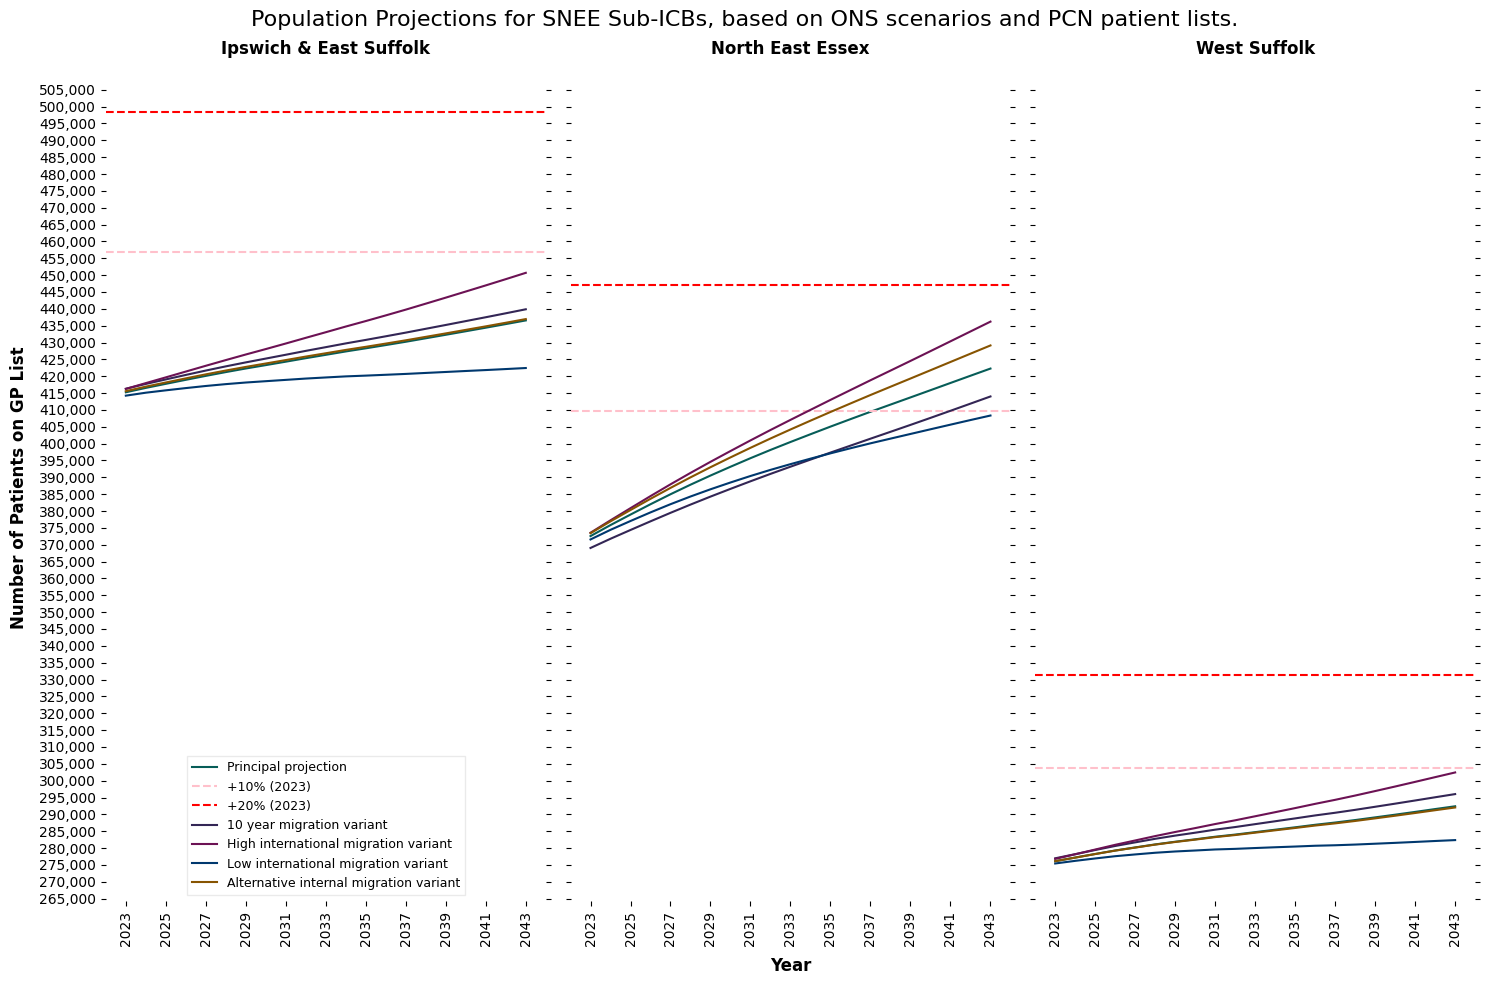

In [19]:


fig, axes = plt.subplots(1,3,figsize=(15,10), sharey=True)
fig.suptitle("Population Projections for SNEE Sub-ICBs, based on ONS scenarios and PCN patient lists.", fontsize=16)
scenario_count = 0
for scenario_name, scenario_df in gp_list_projections.items():
    scenario_total_df_ = scenario_df.copy().reset_index().rename(columns={'AREA_CODE':'Sub-ICB','AGE_GROUP_5':'Age Band'})
    scenario_total_df_ = scenario_total_df_.groupby('Sub-ICB').sum(numeric_only=True).T
    scenario_total_df_.index.name = 'Year'

    
    for i, sub_icb in enumerate(scenario_total_df_.columns):
        axes[i].yaxis.set_major_locator(ticker.MultipleLocator(5000))
        # set y format to show thousands
        axes[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(2))
        # show y ticks
        axes[i].yaxis.set_ticks_position('both')
        axes[i].plot(scenario_total_df_[sub_icb], label=scenario_name)
        # set ticks on y axis to 10000 per tick
        axes[i].set_title(sub_icb)
        # add y gridlines
        axes[i].grid(axis='y')

        if i == 0:
            axes[i].set_ylabel('Number of Patients on GP List')
        if i == 1:
            axes[i].set_xlabel('Year')

        if scenario_name == 'Principal projection':
            axes[i].axhline(y=scenario_total_df_[sub_icb].iloc[0]*1.1, color='pink', linestyle='--', label='+10% (2023)')
            axes[i].axhline(y=scenario_total_df_[sub_icb].iloc[0]*1.2, color='r', linestyle='--', label='+20% (2023)')

        

        # rotate the x-axis labels
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(90)
    scenario_count += 1

axes[0].legend()
plt.tight_layout()
plt.savefig(f"{plot_counter.plot_name}.png", dpi=300, bbox_inches='tight')

### Over 65's Scenarios

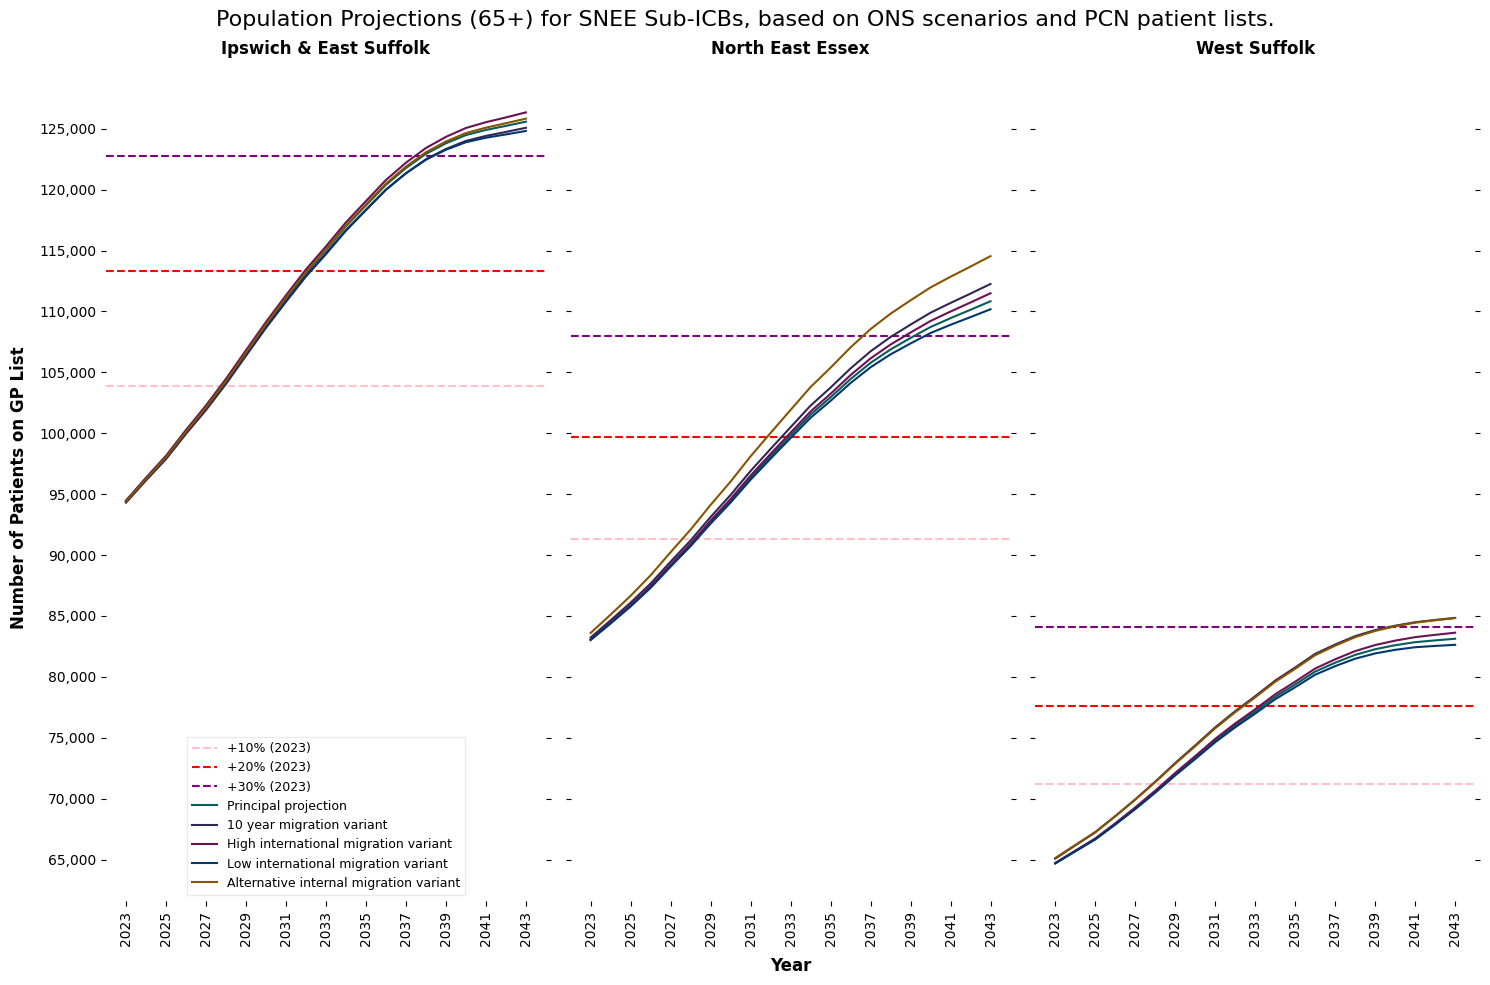

In [20]:

fig, axes = plt.subplots(1,3,figsize=(15,10), sharey=True)
fig.suptitle("Population Projections (65+) for SNEE Sub-ICBs, based on ONS scenarios and PCN patient lists.", fontsize=16)
scenario_count = 0
for scenario_name, scenario_df in gp_list_projections.items():
    scenario_total_df_ = scenario_df.copy().reset_index().rename(columns={'AREA_CODE':'Sub-ICB','AGE_GROUP_5':'Age Band'})
    scenario_total_df_ = scenario_total_df_.loc[scenario_total_df_['Age Band'].isin(OVER_65_LABELS)]
    
    scenario_total_df_ = scenario_total_df_.groupby('Sub-ICB').sum(numeric_only=True).T
    scenario_total_df_.index.name = 'Year'

    # if scenario_name == 'Principal projection':
    #     for column in scenario_total_df_.columns:
    #         ten_percents[column] = scenario_total_df_[column].iloc[0] * 1.1
    #         twenty_percents[column] = scenario_total_df_[column].iloc[0] * 1.2
        


    
    for i, sub_icb in enumerate(scenario_total_df_.columns):
        axes[i].yaxis.set_major_locator(ticker.MultipleLocator(5000))
        # set y format to show thousands
        axes[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(2))

        if scenario_name == 'Principal projection':
            axes[i].axhline(y=scenario_total_df_[sub_icb].iloc[0]*1.1, color='pink', linestyle='--', label='+10% (2023)')
            axes[i].axhline(y=scenario_total_df_[sub_icb].iloc[0]*1.2, color='r', linestyle='--', label='+20% (2023)')
            axes[i].axhline(y=scenario_total_df_[sub_icb].iloc[0]*1.3, color='purple', linestyle='--', label='+30% (2023)')
        # show y ticks
        axes[i].yaxis.set_ticks_position('both')
        axes[i].plot(scenario_total_df_[sub_icb], label=scenario_name)
        # set ticks on y axis to 10000 per tick
        axes[i].set_title(sub_icb)
        
        # add y gridlines
        axes[i].grid(axis='y')

        if i == 0:
            axes[i].set_ylabel('Number of Patients on GP List')
        if i == 1:
            axes[i].set_xlabel('Year')

        # rotate the x-axis labels
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(90)
    scenario_count += 1

axes[0].legend()
plt.tight_layout()
plt.savefig(f"{plot_counter.plot_name}.png", dpi=300, bbox_inches='tight')

## Export the data

In [21]:
template_df = gp_list_projections['Principal projection'].copy().reset_index()

# create a dictionary with year : 0
years_template_dict:Dict[int,int] = {year: 0 for year in template_df.columns[2:]}
groups_template_dict:Dict[str,dict] = {group : years_template_dict.copy() for group in template_df['AGE_GROUP_5'].unique()}
template_dict = {area:groups_template_dict.copy() for area in template_df['AREA_CODE'].unique()}
scenarios_template_dict = {scenario:template_dict.copy() for scenario in gp_list_projections.keys()}

for scenario, scenario_df in gp_list_projections.items():
    for index, row in scenario_df.copy().reset_index().iterrows():
        row_dict = row.to_dict()
        area = row_dict.pop('AREA_CODE')
        ages = row_dict.pop('AGE_GROUP_5')
        scenarios_template_dict[scenario][area][ages] = {int(k):v for k,v in row_dict.items()}

In [22]:
with open(constants.POPULATION_PROJECTIONS_OUTPUT_FILENAME, 'w') as file:
    documents = yaml.dump(scenarios_template_dict, file, default_flow_style=False)